Application of Population Predictive Checks to Nonmentioned Bayesian Models 

## Probabilistic Matrix Factorization using the MovieLens Dataset

In [1]:
%matplotlib inline
import time

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle 

from numpy.linalg import inv
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

In [2]:
# Run this when you haven't created a indexed_ratings.csv yet
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/download
ratings_df = pd.read_csv('../data/the-movies-dataset/ratings_small.csv')

# Check the minimum number of ratings a user has posted
print('Minimum number of ratings for each user is ' + str(ratings_df.groupby('userId').size().min()))
print('Minimum number of ratings for each movie is ' + str(ratings_df.groupby('movieId').size().min()))

Minimum number of ratings for each user is 20
Minimum number of ratings for each movie is 1


We will only use movies that have more than 4 ratings, to have more training data available per movie.

In [3]:
# We will only use part of the data that has more than 4 reviews per movie
moviecounts = ratings_df.movieId.value_counts()
ratings_df = ratings_df[ratings_df.movieId.isin(moviecounts.index[moviecounts.gt(4)])].reset_index(drop=True)
print('Minimum number of ratings for each movie is ' + str(ratings_df.groupby('movieId').size().min()))

Minimum number of ratings for each movie is 5


In [4]:
# Run this when you DON'T have a train_ratings.csv 
# Randomly split the data into train and test
# Specifically, take 5 random ratings out of each user's rating list (therefore, there will be 5 times # of user ratings in the test set)
# For each user id, take out 5 ratings oaut of the dataframe then append them into a new dataframe.
# Then take the difference of the two data frames and the difference will be the train data

def train_test_split_mf(ratings_df):
    for userid in ratings_df.userId.unique() :
        if userid == 1:
            test_ratings = ratings_df[ratings_df['userId']==userid].sample(5, random_state=0)
        else:
            test_ratings = test_ratings.append(ratings_df[ratings_df['userId']==userid].sample(5, random_state=0))
    train_ratings = pd.concat([ratings_df, test_ratings]).drop_duplicates(keep=False).reset_index(drop=True)
    test_ratings = test_ratings.reset_index(drop=True)
    print("Number of ratings in entire dataset is "+ str(len(ratings_df)))
    print("Number of ratings in train dataset is "+  str(len(train_ratings)))
    print("Number of ratings in test dataset is "+ str(len(test_ratings)))
    return train_ratings, test_ratings

In [5]:
train_ratings, test_ratings = train_test_split_mf(ratings_df)

Number of ratings in entire dataset is 90072
Number of ratings in train dataset is 86717
Number of ratings in test dataset is 3355


In [6]:
train_ratings.to_csv('../data/train_ratings.csv')
test_ratings.to_csv('../data/test_ratings.csv')

In [7]:
train_ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1061,3.0,1260759182
2,1,1129,2.0,1260759185
3,1,1172,4.0,1260759205
4,1,1263,2.0,1260759151
...,...,...,...,...
86712,671,6212,2.5,1065149436
86713,671,6269,4.0,1065149201
86714,671,6365,4.0,1070940363
86715,671,6385,2.5,1070979663


We split randomly the data into train and test data. Specifically, we take 5 random ratings out of each user's rating list, creating 5 x (num of users) ratings in the test set. The remaining data becomes the training set.

In [8]:
# Run this when you have a train_ratings.csv 
train_ratings = pd.read_csv('../data/train_ratings.csv', index_col=0)
test_ratings = pd.read_csv('../data/test_ratings.csv', index_col=0)

Since the IDs of the users and movies have gaps in between, we reindex the IDs so that it will be easier to manipulate the user x movie ratings matrix.

In [10]:
# Run this when you DON'T have a indexed_train_ratings.csv 
# Reindexing of userId and movieId
unique_userId = train_ratings.userId.unique()
unique_movieId = train_ratings.movieId.unique()

train_ratings['new_user_index'], train_ratings['new_movie_index'] = 0, 0

for old_id, new_id in zip(unique_userId, range(len(unique_userId))):
    train_ratings['new_user_index'].iloc[train_ratings[train_ratings['userId']==old_id].index.tolist()] = new_id

for old_id, new_id in zip(unique_movieId, range(len(unique_movieId))):
    train_ratings['new_movie_index'].iloc[train_ratings[train_ratings['movieId']==old_id].index.tolist()] = new_id

train_ratings.to_csv('../data/indexed_train_ratings.csv')

/Users/nishimura_yuki/workspace/mlpp/pop-pc/pop-pc/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Run this when you have a indexed_train_ratings.csv 
train_ratings = pd.read_csv('../data/indexed_train_ratings.csv', index_col=0)

Distribution of All Ratings (with more than 4 reviews)

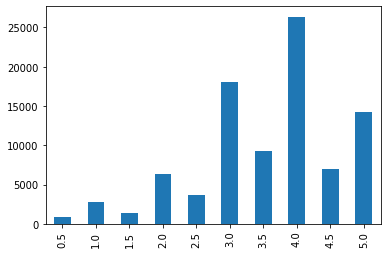

In [12]:
# Distribution of All Ratings (with more than 4 reviews)
ratings_df['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Distribution of Train Data Ratings

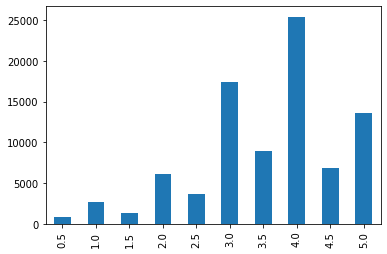

In [13]:
# Distribution of Train Data Ratings
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Distribution of Train Data Ratings

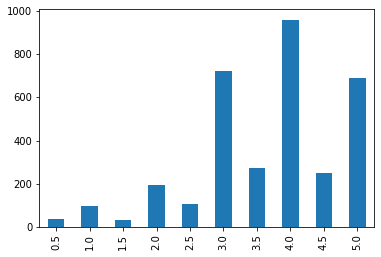

In [14]:
# Distribution of Test Data Ratings
test_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Now we implement the Probabilistic Matrix Factorization (PMF) model, and train the model using the train dataset. In our case, PMF 's objective is to fill in the missing values of the movie matrix $M$, by maximizing the following MAP objective function.

$L = - \Sigma_{(i,j)\in \Omega}\frac{1}{2\sigma^2}(M_{ij}-u_i^Tv_j)^2-\Sigma_{i=1}^{N_u}\frac{\lambda}{2}||u_i||^2-\Sigma_{j=1}^{N_v}\frac{\lambda}{2}||v_j||^2$,

where $u_i$ is the $i$th user vector, $v_j$ the $j$th movie vector, $N_u$ the number of users, $N_v$ the number of movies, $\Omega$ the set of $(i,j)$s that have a rating in the matrix $M$, $\sigma^2$ the variance of $M_{ij} \sim N(u_i^Tv_j, \sigma^2)$. Therefore, each rating in $M$ are assumed to be normally distributed. Also, note that the each user vector $u_i$ and movie vector $v_j$ are initialized from the distribution $N(0, \lambda^{-1}I)$, where $u$ is a $i \times k$ matrix and $v$ is a $j \times k$ matrix.

We have implemented the model below.

#### Imputation of train data using the mean ratings of each user

In [20]:
# Run this when you DON'T have a mean_imputated_ratings.npy

imputated_ratings = np.empty((ratings_df.userId.nunique(),ratings_df.movieId.nunique()))

for user in range(ratings_df.userId.nunique()):
    imputated_ratings[user] = train_ratings[train_ratings.new_user_index == user]['rating'].mean()
    for column in train_ratings[train_ratings.new_user_index == user]['new_movie_index']:
        imputated_ratings[user, column] = train_ratings[(train_ratings.new_user_index == user)&(train_ratings.new_movie_index == column)]['rating']   

np.save('../data/mean_imputated_ratings.npy', imputated_ratings)

In [21]:
# Run this when you have a imputated_ratings.npy
imputated_ratings = np.load('../data/mean_imputated_ratings.npy')

### Model

In [22]:
# Implementation of Probabilistic Matrix Factorization using Pyro
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    r = pyro.sample("obs", dist.Normal(torch.mm(u,v.T), 1), obs=data)

In [23]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) 
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 30/30 [36:07, 72.26s/it, step size=2.31e-02, acc. prob=0.102] 


#### Imputation of train data using zeros

In [26]:
# Run this when you DON'T have a zero_imputated_ratings.npy

zero_imputated_ratings = np.empty((ratings_df.userId.nunique(),ratings_df.movieId.nunique()))

for user in range(ratings_df.userId.nunique()):
    zero_imputated_ratings[user] = 0
    for column in train_ratings[train_ratings.new_user_index == user]['new_movie_index']:
        zero_imputated_ratings[user, column] = train_ratings[(train_ratings.new_user_index == user)&(train_ratings.new_movie_index == column)]['rating']  

np.save('../data/zero_imputated_ratings.npy', zero_imputated_ratings)

In [27]:
# Run this when you have a zero_imputated_ratings.npy
zero_imputated_ratings = np.load('../data/zero_imputated_ratings.npy')

In [28]:
# Implementation of Probabilistic Matrix Factorization using Pyro
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings_df.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings_df.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    r = pyro.sample("obs", dist.Normal(torch.mm(u,v.T), 1), obs=data)

In [ ]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) 
mcmc = MCMC(kernel, num_samples=100, warmup_steps=100)
mcmc.run(torch.tensor(zero_imputated_ratings))
posterior_samples_zero = mcmc.get_samples()

warmup:  10%|▉         | 19/200 [31:15, 165.13s/it, step size=1.24e-03, acc. prob=0.695]

In [ ]:
with open('pmf_dict.pickle', 'wb') as handle:
    pickle.dump(posterior_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
for i in range(5):
    print(torch.mm(posterior_samples['u'][i,:,:], posterior_samples['v'][i,:,:].T))

tensor([[2.5074, 2.5600, 2.5339,  ..., 2.5655, 2.6665, 2.5768],
        [3.3995, 3.5710, 3.4838,  ..., 3.4515, 3.5039, 3.4816],
        [3.4559, 3.5129, 3.5830,  ..., 3.5499, 3.5840, 3.4749],
        ...,
        [3.3668, 3.5615, 3.6083,  ..., 3.5593, 3.5830, 3.4344],
        [3.7670, 3.9039, 3.7156,  ..., 3.8006, 3.8391, 3.8391],
        [3.8463, 4.0061, 3.9183,  ..., 3.9202, 3.9313, 3.9392]])
tensor([[2.5157, 2.5650, 2.4821,  ..., 2.5685, 2.5518, 2.5074],
        [3.5209, 3.4369, 3.4832,  ..., 3.4262, 3.4399, 3.4778],
        [3.5575, 3.5925, 3.4677,  ..., 3.5451, 3.5348, 3.5111],
        ...,
        [3.5937, 3.6177, 3.5960,  ..., 3.5310, 3.5311, 3.5335],
        [3.8014, 3.8146, 3.7779,  ..., 3.7464, 3.7438, 3.7313],
        [3.9435, 3.8593, 3.9115,  ..., 3.9777, 3.9792, 3.9134]])
tensor([[2.5093, 2.3796, 2.6034,  ..., 2.5879, 2.6098, 2.4711],
        [3.4555, 3.4486, 3.4220,  ..., 3.5611, 3.5649, 3.3797],
        [3.5758, 3.5152, 3.5612,  ..., 3.5990, 3.4914, 3.4975],
        ...,

In [ ]:
tensor =  torch.mm(posterior_samples['u'][0,:,:], posterior_samples['v'][0,:,:].T)
for i in range(1,5):
    tensor += torch.mm(posterior_samples['u'][i,:,:], posterior_samples['v'][i,:,:].T)
tensor = tensor/5

In [ ]:
rounded_estimate_ratings = (tensor* 2).round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5
print(rounded_estimate_ratings)

In [ ]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])
rounded_estimate_ratings_counts

In [ ]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

It seems like the predicted data is distributed normally, due to the fact that the PMF assumes a normal distribution on its ratings, and the variance of each ratings are the same. Therefore, there seems to be space for improvement.

In [ ]:
# Bayesian PMF using Pyro
# Reference https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings.userId.nunique()):
        with pyro.plate('user_k', k):
            p_u_mu = pyro.sample('p_u_mu', dist.Normal(0, 1))
            p_u_std = pyro.sample('p_u_std', dist.InverseGamma(1,1))
            u = pyro.sample('u', dist.Normal(p_u_mu, p_u_std))
    with pyro.plate('movies', ratings.movieId.nunique()):
        with pyro.plate('movie_k', k):
            p_v_mu = pyro.sample('p_v_mu', dist.Normal(0, 1))
            p_v_std = pyro.sample('p_v_std', dist.InverseGamma(1,1))
            v = pyro.sample('v', dist.Normal(p_v_mu, p_v_std))
    with pyro.poutine.mask(mask=is_observed):
        pyro.sample("obs", dist.Normal(torch.mm(u.T,v), 1), obs=data)

In [ ]:
# POP-PC
# Cross validation POP-PC
# Randomly remove ratings from train data, and keep possession of them to check later on 
# Train the model, then compare the entire data distribution and the ratings distributions of each user.

Using Posterior Predictive Check (PPC) to criticize this model, 

In [ ]:
# PPC 
# get distribution of ratings from the entire data, and for each user
# get distribution of ratings from the predicted entire data, and predictions for each user
# check if the discrepancies are close to each other

# Discrepancies of original data
# Max and min ratings are trivially the same
mean_rating = train_ratings['rating'].mean()
median_rating = train_ratings['rating'].median()
first_q_rating = np.quantile(train_ratings['rating'],0.25)
third_q_rating = np.quantile(train_ratings['rating'],0.75)

# Discrepancies of trained_data
pred_mean_rating = torch.mean(rounded_estimate_ratings)
pred_median_rating = torch.median(rounded_estimate_ratings)
pred_first_q_rating = np.quantile(rounded_estimate_ratings.numpy(),0.25)
pred_third_q_rating = np.quantile(rounded_estimate_ratings.numpy(),0.75)

print('Discrepancy of mean ratings: ' + str(mean_rating - pred_mean_rating))
print('Discrepancy of median ratings: ' + str(median_rating - pred_median_rating))
print('Discrepancy of first_q ratings: ' + str(first_q_rating - pred_first_q_rating))
print('Discrepancy of third_q ratings: ' + str(third_q_rating - pred_third_q_rating))

We compared the distribution of the train data ratings with the predicted $M^{\prime}$ ratings. The discrepancies of the distributions are big considering that the values of ratings are between 0.5~5, which means that the PMF model is not performing well. This is trivial when you compare the two distributions visually.

In [ ]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])

Distribution of ratings in the predicted $M^{\prime}$

In [ ]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

Distribution of Train Data Ratings

In [ ]:
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

### References

- Population Predictive Checks https://arxiv.org/abs/1908.00882
- Probabilistic Matrix Factorization https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf
- Bayesian Probabilistic Matrix Factorization using Markov Chain Monte Carlo https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf
- Scalable Recommendation with Poisson Factorization https://arxiv.org/pdf/1311.1704.pdf

### Appendix

Non-Pyro Implementation of Probabilistic Matrix Factorization (Could achieve PMF without using imputed values)

In [ ]:
# Reference: https://sandipanweb.wordpress.com/2017/04/04/probabilistic-matrix-factorization-with-a-generative-model-in-python/
# Implementation of Probabilistic Matrix Factorization from the above reference
class PMF:
    def __init__(self, k, prior_mean=0, prior_std=1, epochs=20):
        self.k = k
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.epochs = epochs
        self.u = None
        self.v = None
        self.M_prime = None

    def fit(self, data):
        ratings = data
        self.I = ratings.userId.nunique()
        self.J = ratings.movieId.nunique()
        self.u = pyro.sample("user_factor", dist.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.I,self.k]))
        self.v = pyro.sample("movie_factor", dist.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.J,self.k]))
        self.data_var = ratings['rating'].var(axis=0)
        
        user_to_movie_dict = {}
        movie_to_user_dict = {}

        for i in range(self.I):
            user_to_movie_dict[i] = ratings[ratings['new_user_index']==i]['new_movie_index'].tolist()
        for j in range(self.J):
            movie_to_user_dict[j] = ratings[ratings['new_movie_index']==j]['new_user_index'].tolist()
            
        for epoch_num in range(self.epochs):
            # Update of all u_i: Took 110.703 seconds on Yuki's cp
            for i in range(len(self.u)):
                v_sum = 0
                mv_sum = 0
                for j in user_to_movie_dict[i]:
                    v_sum += np.outer(self.v[j],self.v[j])
                    mv_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.v[j]
                self.u[i] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + v_sum), mv_sum))

            # Update of all v_j: Took 106.218 seconds on Yuki's cp
            for j in range(len(self.v)):
                u_sum = 0
                mu_sum = 0
                for i in movie_to_user_dict[j]:
                    u_sum += np.outer(self.u[i],self.u[i])
                    mu_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.u[i]
                self.v[j] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + u_sum), mu_sum))

            self.M_prime = torch.mm(self.u,self.v.T)
            error = 0
            for i in range(len(self.u)):
                for j in user_to_movie_dict[i]:
                    error += (float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) - self.M_prime[i][j])**2
            print('MSE of Epoch ' + str(epoch_num) + ': ' + str(float(error/len(ratings))))

We train the PMF using $k=10$ and 20 epochs.

In [ ]:
PMF_self = PMF(10)
PMF_self.fit(train_ratings)

Retrieving the predicted $M^{\prime}$ with the filled missing values, 

In [ ]:
estimate_ratings = PMF_self.M_prime

In [ ]:
# Round the estimated ratings to the closest .5 rating between 0.5 and 5
rounded_estimate_ratings = (estimate_ratings * 2).round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5

In [ ]:
# Save trained model
with open('10k20epochPMF.pkl', 'wb') as output:
    pickle.dump(model_k10_e20, output, pickle.HIGHEST_PROTOCOL)